[View in Colaboratory](https://colab.research.google.com/github/redcican/BANKSapi/blob/master/2_Classification_Vendor_Payment.ipynb)

# Classification Problem

In the previous notebook, I hvae walked through the traditional NLP methods such as **CountVectorizer**, **TF-IDF** to extract meaningful features from text data. In this notebook, I will be looking at more advanced feature enginneering strategies which often leverage **Deep Learning** models. More specifically I will be covering the [**GloVe**](https://nlp.stanford.edu/projects/glove/).

In [0]:
# General
import numpy as np
import pandas as pd
import os
import string

# Pre-Processing
import nltk
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
from nltk.util import ngrams
from collections import Counter
from gensim.models import word2vec

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# model selection
from sklearn.model_selection import train_test_split

# keras for deep learning
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

# model save and reload
import pickle
from tqdm import tqdm
# Warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Import the data  

Because this task only requires two varialbes, `Recipient` and `Description` and a flexible combination of `AgyCode` and `SubObject`. We will only use this columns in this notebook

In [0]:
pd.set_option('max_colwidth', 500)
df = pd.read_csv('state_vendor_payment.csv',usecols=['AgyCode','SubObject','Recipient','Description'])
df.head()

,AgyCode,SubObject,Recipient,Description
0,10,CC,MONTAGUE DEROSE & ASSOCIATES LLC,"The amounts expended for financial services, actuarial services, economic analysis, cost/benefit analysis, cost allocation, accounting and financial audit services. Also includes investment management, cash management and stockbroker services."
1,10,CB,FOSTER PEPPER PLLC,"The amounts expended for legal services and legal research and consultation by non-state employed attorneys, bond counsel, patent counsel, hearing examiners, etc. Expert witness contracts are for the purpose of providing expert testimony in litigation, but may also include other services such as case consultation, research, and legal services. Does not include services for court reporters, legal aides or lay witnesses, which are classified as purchased services under Subobject ER."
2,10,ER,FITCH INC,"The amounts expended for contractual services provided to accomplish routine, continuing and necessary functions not otherwise specifically mentioned or included under the other subobjects within Object E “Goods and Services,” Object C “Personal Service Contracts,” Object N “Grants, Benefits, and Client Services,” or Subobject JK “Architectural and Engineering Services.” Other contractual services could include, but are not limited to, custodial, interagency, court reporters, lay witnesses, ..."
3,10,ER,MOODYS INVESTORS SERVICE,"The amounts expended for contractual services provided to accomplish routine, continuing and necessary functions not otherwise specifically mentioned or included under the other subobjects within Object E “Goods and Services,” Object C “Personal Service Contracts,” Object N “Grants, Benefits, and Client Services,” or Subobject JK “Architectural and Engineering Services.” Other contractual services could include, but are not limited to, custodial, interagency, court reporters, lay witnesses, ..."
4,10,EZ,FEDERAL EXPRESS,"The amounts expended for goods and services other than those described above. Includes such items as bonds, freight (when not allocable to items purchased), advertising, and other goods and services from vendors or other agencies."


## 2. Explore the target column

To make task simpler, I decided to merge `AgyCode` and `SubObject` into a new target column called `Agycode-Subobject`

In [0]:
df["Agycode-Subobject"] = df["AgyCode"].map(str) + df["SubObject"]

In [0]:
'''
nltk.download('stopwords')

from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    words = [w for w in words if not w in stop_words] #3
    return words
'''

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We can first check the distribution of the labels.

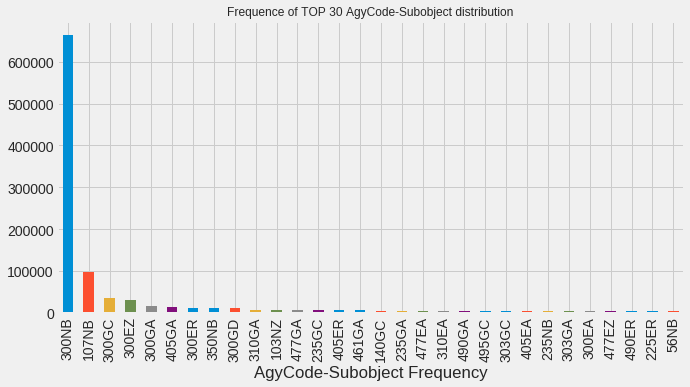

In [0]:
plt.figure(figsize=(10,5))
df["Agycode-Subobject"].value_counts().nlargest(30).plot(kind='bar')
plt.xlabel('AgyCode-Subobject Frequency')
plt.title('Frequence of TOP 30 AgyCode-Subobject distribution',fontsize=12)
plt.show()

We can see that the distribution of labels is quite heterogeneous. the label `300NB` and `107NB` occupy almost a half of labels, which leads a quite unbalanced classification problem.

In [0]:
# check the percentile of the 300NB and 107NB
sum(df["Agycode-Subobject"].value_counts().nlargest(2))/len(df)

0.4986615310038747

Handling such huge and unbalanced labels can be very difficult, so I decide to convert the mutli classes problem to a binary classes problem. I resorted the label `300NB` and `107NB` to label 1 and the remaining lables to 0.

In [0]:
df['label'] = (df['Agycode-Subobject'] =="300NB") | (df['Agycode-Subobject'] == "107NB")

We convert the label to integer.

In [0]:
df['label'] = df['label'].astype(int)

Now, we can check the distribution of our new labels.

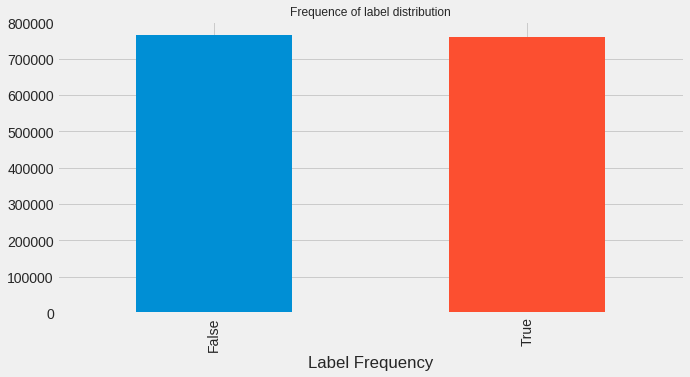

In [0]:
plt.figure(figsize=(10,5))
df["label"].value_counts().plot(kind='bar')
plt.xlabel('Label Frequency')
plt.title('Frequence of label distribution',fontsize=12)
plt.show()

## 3. Feature Engineering  

After gaining the sufficient understanding of the data from the EDA of first notebook, we can quickly apply deep learning to our features.

In [0]:
X = df[['Recipient','Description']]
y= np_utils.to_categorical(df['label'],2)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,random_state=42, test_size=0.1, shuffle=True)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:' ,y_test.shape)

X_train shape: (1372052, 2)
X_test shape: (152451, 2)
y_train shape: (1372052, 2)
y_test shape: (152451, 2)


Unlike previous notebook by using Scikit-learn, here we use [Keras text preprocessing](https://keras.io/preprocessing/text/). It provides a similar function to extract the feature from text, but more straightforward. We first tokenzize the text to a sequence of integers and then pad them to the same length. 

In [0]:
token = text.Tokenizer(num_words=10000)
max_len_1 = 70
max_len_2 = 10
token.fit_on_texts(list(X_train.Recipient) + list(X_train.Description))
token.fit_on_texts(list(X_test.Recipient) + list(X_test.Description))

X_train_Recip = token.texts_to_sequences(X_train.Recipient)
X_train_Desc = token.texts_to_sequences(X_train.Description)
X_test_Recip = token.texts_to_sequences(X_test.Recipient)
X_test_Desc = token.texts_to_sequences(X_test.Description)

In [0]:
X_train_Recip_pad = sequence.pad_sequences(X_train_Recip, maxlen=max_len_2)
X_train_Desc_pad = sequence.pad_sequences(X_train_Desc, maxlen=max_len)
X_test_Recip_pad = sequence.pad_sequences(X_test_Recip, maxlen=max_len_2)
X_test_Desc_pad = sequence.pad_sequences(X_test_Desc, maxlen=max_len)

word_index = token.word_index

In [0]:
'''
The following code is used to save word_index 
locally and reload it.

'''
pickle.dump(word_index, open('word_index.pkl','wb'),-1)

word_index = open('word_index.pkl','rb')
word_index = pickle.load(word_index)

We can use `np.hstack` stack our two features.

In [0]:
X_train = np.hstack((X_train_Recip_pad,X_train_Desc_pad))
X_test = np.hstack((X_test_Recip_pad, X_test_Desc_pad))
print(X_train.shape)
print(X_test.shape)

(1372052, 80)
(152451, 80)


In [0]:
'''
The following code is used to save X_train 
and X_test locally and reload it. To load X_train
and X_test locally, uncommented the code!

'''

pickle.dump(X_train, open('X_train.pkl','wb'),-1)
pickle.dump(X_test, open('X_test.pkl','wb'),-1)
#X_train = open('X_train.pkl','rb')
#X_train = pickle.load(X_train)
#X_test = open('X_test.pkl','rb')
#X_test = pickle.load(X_test)

The GloVe model stands for **Global Vectors** which is an unsupervised learning model which can be used to obtain dense word vectors. To use it, we should first download it!

In [0]:
'''
Download and unzip the GloVe

'''

!wget https://nlp.stanford.edu/data/wordvecs/glove.42B.300d.zip

--2018-09-09 18:12:24--  https://nlp.stanford.edu/data/wordvecs/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877802108 (1.7G) [application/zip]
Saving to: ‘glove.42B.300d.zip’

glove.42B.300d.zip  100%[===================>]   1.75G  18.4MB/s    in 98s     

2018-09-09 18:14:03 (18.2 MB/s) - ‘glove.42B.300d.zip’ saved [1877802108/1877802108]



In [0]:
!unzip glove.42B.300d.zip

Archive:  glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


The code below is used to load the Glove vectors in a dictionary.

In [0]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('glove.42B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

1917495it [02:39, 12048.94it/s]

Found 1917495 word vectors.


We have to create a embedding matrix to overcome the losing out of semantics and feature sparsity. 

In [0]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 71668/71668 [00:00<00:00, 335736.95it/s]


In [0]:
'''
As previous, these code is used to save and reload
embedding_matrix.

'''
pickle.dump(embedding_matrix, open('embedding_matrix.pkl','wb'),-1)
embedding_matrix = open('embedding_matrix.pkl','rb')
embedding_matrix = pickle.load(embedding_matrix)

In [0]:
embedding_matrix.shape

(71669, 300)

## 4. Deep Learning using LSTM

In [0]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=80,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

# you can uncommented the next line if you have not GPU available. 
#model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

The reason why I love Deep Learning is that it can utilize the power of GPUs and accelerate the training process. The following codes only works if you have GPUs available. You can change the parameter `gpus` according to your conditions.

In [0]:
from keras.utils import multi_gpu_model

# Replicates `model` on 8 GPUs.
# This assumes that your machine has 8 available GPUs.
parallel_model = multi_gpu_model(model, gpus=8)
parallel_model.compile(loss='categorical_crossentropy',
                        optimizer='adam',metrics=['accuracy'])

# This `fit` call will be distributed on 8 GPUs.
# Since the batch size is 256, each GPU will process 32 samples.
parallel_model.fit(X_train, y_train, batch_size=128, epochs=2, verbose=2, validation_split=0.1)

Train on 1234846 samples, validate on 137206 samples
Epoch 1/2
 - 3880s - loss: 0.1073 - acc: 0.9729 - val_loss: 0.1057 - val_acc: 0.9733
Epoch 2/2
 - 3668s - loss: 0.1071 - acc: 0.9729 - val_loss: 0.1056 - val_acc: 0.9733


After two epochs, we got a validation accuracy of 97%, which is quite well. To reuse the model, we can save it locally.

In [0]:
import keras
my_model = keras.models.load_model('my_model.h5')
my_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 140)          0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 140)          0           embedding_1_input[0][0]          
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 140)          0           embedding_1_input[0][0]          
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 140)          0           embedding_1_input[0][0]          
__________________________________________________________________________________________________
lambda_4 (

We can evaluate our model on the testing set. 

In [0]:
loss, acc = my_model.evaluate(X_test, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

152451/152451 [==============================] - 4085s 27ms/step
Restored model, accuracy: 97.31%


## 5. Final Thought

This notebook focuses on the deep learning, there are of course another popular techniques usch as **word2vec** and **FastText**. Compare to the other machine learning algorithms like **xgboost**, the deep learning models take much more time to train a model since usually it has a large amount of parameters. The binary labels method is actually tricky, but I have tried not to binarize them, just trained a model to predict over 3000 labels. It actually works, but the performance of model is quite unsatisfactory. 